# Define the client

The client, Max, is a one-man start up team looking for an area with an abundance of smaller web/software companies where the cost of living tends to be lower. The assumption is that a higher quantity of smaller web/software comapnies will means a larger network/community of start-up support including incubators, mentorship programs, and meetups. Max is also interested in an area with a low cost of living so he can afford to purchase a hosue.

Plan:

Create two choropleth maps:
(a) Shows number of smaller web-software comapnies by US Zip Code
(b) Shows home prices by US Zip Code

(c) Preform some kind of filter function of the data from the previous maps to find the best city

----
# resources:
https://python-visualization.github.io/folium/quickstart.html

In [1]:
# Import libraries
import pymongo
from pymongo import MongoClient
import pandas as pd
import seaborn as sns
%matplotlib inline
import json
import re
import folium
from folium import GeoJson
from pandas.io.json import json_normalize

In [2]:
# Connect to the local database
client = MongoClient()
db = client.companies

# Establish comp as alias for collection "companies"
comp = db.companies

In [3]:
# Get the median number of employyes for web and software comapnies
cursor = comp.find({
    "category_code": {"$in":["web", "software"]},
    "number_of_employees": {"$gt": 0}
},{"number_of_employees": 1, "_id": 0})

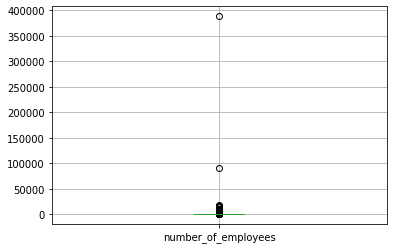

In [4]:
pd.DataFrame(list(cursor)).boxplot()

In [5]:
# We want companies that are smaller the 20
cursor = comp.find({
    "category_code": {"$in":["web", "software"]},
    "number_of_employees": {"$gt": 0, "$lt": 20}
},{"number_of_employees": 1, "_id": 0})

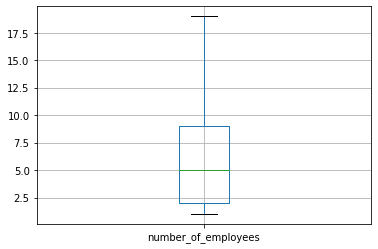

In [6]:
pd.DataFrame(list(cursor)).boxplot()

In [7]:
# Rewind cursor to get length
cursor.rewind()
len(list(cursor))

2431

# We want the 2431 companies in web/software with less than 20 employees


In [8]:
cursor = comp.find({
    "category_code": {"$in":["web", "software"]},
    "offices.country_code": "USA",
    "number_of_employees": {"$gt": 0, "$lt": 20}
},{"_id": 0, "offices.zip_code": 1, "name": 1})

In [9]:
zipData = pd.DataFrame(json_normalize(list(cursor)))
zipData.head(50)

,name,offices
0,Geni,[{'zip_code': '90069'}]
1,Ikan,[{'zip_code': '06902'}]
2,Pownce,[{'zip_code': '94107'}]
3,CriticalMetrics,[{'zip_code': None}]
4,ClipBlast!,[{'zip_code': '91301'}]
5,Spotplex,[{'zip_code': '95054'}]
6,TripHub,[{'zip_code': '98121'}]
7,CrowdVine,[{'zip_code': '94941-2464'}]
8,Newsvine,[{'zip_code': '98119'}]
9,Terabitz,[{'zip_code': '94306-2123'}]


In [10]:
# Probably would have been better to do this with JSON normalize
zipData['zip'] = zipData['offices'].map(lambda x: re.sub("\D", "", str(x)))
zipCounts = zipData['zip'].value_counts().reset_index()
zipCounts

,index,zip
0,,142
1,94107,17
2,94301,17
3,94103,15
4,94111,10
...,...,...
636,06902,1
637,97007,1
638,941053620,1
639,3500034231,1


In [11]:
# Read in geoson file
#zip_code_areas = GeoJson('us_zip_code.geojson')

In [12]:
myData = pd.read_json('us_zip_code.geojson')

type          object
geometries    object
dtype: object

In [22]:
zipCounts['ZCTA5CE10'] = zipCounts['index']
zipCounts['counts'] = zipCounts['zip']
zipCounts


,index,zip,ZCTA5CE10,counts
0,,142,,142
1,94301,17,94301,17
2,94107,17,94107,17
3,94103,15,94103,15
4,94111,10,94111,10
...,...,...,...,...
636,91364,1,91364,1
637,11030,1,11030,1
638,85281,1,85281,1
639,981099267,1,981099267,1


In [25]:
# Get the indexes for the columns when the zip code is empty or the length doesn't equal five
zipCounts['validCode'] = zipCounts['ZCTA5CE10'].apply(lambda num: "False" if len(num)!=5 or not num else "True")

# Get rid of these
zipCounts = zipCounts[zipCounts['validCode'] == "True"]

In [28]:
zipCounts

,index,zip,ZCTA5CE10,counts,validCode
1,94301,17,94301,17,True
2,94107,17,94107,17,True
3,94103,15,94103,15,True
4,94111,10,94111,10,True
5,10011,9,10011,9,True
...,...,...,...,...,...
634,20010,1,20010,1,True
636,91364,1,91364,1,True
637,11030,1,11030,1,True
638,85281,1,85281,1,True


In [27]:
m = folium.Map(location=[48, -102], zoom_start=3)

folium.Choropleth(
    geo_data='us_zip_code.geojson',
    name='choropleth',
    data=zipCounts,
    columns=['ZCTA5CE10', 'counts'],
    key_on='feature.properties.ZCTA5CE10',
    fill_color='YlGn',
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name='Zip Codes With the Most Small Startups'
).add_to(m)

folium.LayerControl().add_to(m)

m

AttributeError: 'NoneType' object has no attribute 'get'

In [ ]:
import ssl

ssl._create_default_https_context = ssl._create_unverified_context

url = 'https://raw.githubusercontent.com/python-visualization/folium/master/examples/data/'
state_geo = f'{url}/us-states.json'
state_unemployment = f'{url}/US_Unemployment_Oct2012.csv'
state_data = pd.read_csv(state_unemployment)

In [ ]:
state_data

In [ ]:
m = folium.Map(location=[48, -102], zoom_start=3)

folium.Choropleth(
    geo_data=state_geo,
    name='choropleth',
    data=state_data,
    columns=['State', 'Unemployment'],
    key_on='feature.id',
    fill_color='YlGn',
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name='Unemployment Rate (%)'
).add_to(m)

folium.LayerControl().add_to(m)

m